# Run inference

* **Last Modified**: 2022
* **Authors**: Gonzalo Mateo-García, Kike Portalés-Julià
---

> Run inference on Sentinel-2 images using a 3-class trained model 

This notebook shows how to load a trained model from a experiment config file. With that model we will then make predictions on new Sentinel-2 images.

In [1]:
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\1\Documents\Projectes\Floods\Credentials\ml4cc-general-access_request_pays.json"

In [2]:
#!pip install ml4floods 

In [3]:
from ml4floods.models.config_setup import get_default_config

experiment_name = 'WF2_unet_full_norm'

path_model = r'X:\home\kike\Projectes\ml4floods\2_MLModelMart'
config_fp = os.path.join(path_model,f"{experiment_name}\config.json").replace("\\","/")
config = get_default_config(config_fp)

Loaded Config for experiment:  WF2_unet_full_norm
{   'data_params': {   'batch_size': 32,
                       'bucket_id': '',
                       'channel_configuration': 'all',
                       'download': {   'test': False,
                                       'train': False,
                                       'val': False},
                       'filter_windows': {   'apply': True,
                                             'threshold_clouds': 0.8,
                                             'version': 'v2'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': '/media/disk/databases/WORLDFLOODS/2_Mart/worldfloods_extra_v2_0',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/home/kike/Projectes/ml4floods/splits/split_full_v2_0.j

In [4]:
from ml4floods.models.model_setup import get_model, get_model_inference_function, get_channel_configuration_bands

config["model_params"]['model_folder'] = rf'X:\home\kike\Projectes\ml4floods\2_MLModelMart'
config["model_params"]['test'] = True
config["model_params"]['train'] = False
config["model_params"]["max_tile_size"] = 1024 

model = get_model(config.model_params, experiment_name)
model.eval()
#model.to("cuda") # comment this line if your machine does not have GPU
inference_function = get_model_inference_function(model, config,apply_normalization=True,activation="sigmoid")
channels = get_channel_configuration_bands(config.data_params.channel_configuration)

Loaded model weights: X:/home/kike/Projectes/ml4floods/2_MLModelMart/WF2_unet_full_norm/model.pt
Getting model inference function
Max tile size: 1024


In [5]:
from typing import Union,Optional,List, Tuple, Callable
import rasterio
import torch
import numpy as np
from ml4floods.data import utils
from ml4floods.data.worldfloods.dataset import load_input


In [6]:
from ml4floods.visualization.plot_utils import get_image_transform


#file = 'EMSR264_18MIANDRIVAZODETAIL_DEL_v2_observed_event_a.tif'
file = 'EMSR342_06NORTHNORMANTON_DEL_v1_observed_event_a.tif'
path_s2 = r'X:\media\disk\databases\WORLDFLOODS\2_Mart\worldfloods_extra_v2_0\test\S2'
tiff_s2 = os.path.join(path_s2,file).replace('\\','/')
tiff_gt = tiff_s2.replace('/S2/','/gt/')

gt = get_image_transform(tiff_gt)[0]
inputs, transform = load_input(tiff_s2,channels)
inputs = inputs.unsqueeze(0)

# Compute the prediction
outputs = inference_function(inputs).squeeze(0) # (batch_size, num_classes, h, w)
outputs = outputs.cpu().numpy()

C:\Users\1\anaconda3\envs\ml4fl_kike\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
from ml4floods.visualization.plot_utils import get_cmap_norm_colors
from ml4floods.models.postprocess import get_pred_mask_v2
from ml4floods.visualization.plot_utils import plot_s2_rbg_image,plot_s2_swirnirred_image, plot_gt_v2, plot_gt_v1


COLORS_WORLDFLOODS = np.array([[0, 0, 0], # invalid
                               [139, 64, 0], # land
                               [0, 0, 139], # water
                               [220, 220, 220]], # cloud
                              dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS = ["invalid", "land", "water", "cloud"]

def plot_inference_set(tiff_s2: str, gt: np.ndarray, 
                       prediction: np.ndarray, transform: rasterio.Affine)->None:
    """
    Plots inputs, targets and prediction into lat/long visualisation
    
    Args:
        tiff_s2: S2 input file
        targets: gt target array
        prediction: predictions output by model 
        transform: transform used to plot with lat/long
    """
    fig, ax = plt.subplots(2,2,figsize=(16,16))
    fig.subplots_adjust(wspace=0.01, hspace = 0.05)

    plot_s2_rbg_image(tiff_s2,transform=transform,size_read=600,ax=ax[0,0])
    ax[0,0].set_title("RGB Composite")
    plot_s2_swirnirred_image(tiff_s2,transform=transform,size_read=600,ax=ax[0,1])
    ax[0,1].set_title("SWIR1,NIR,R Composite")
    plot_gt_v2(gt,transform=transform,ax=ax[1,0])
    ax[1,0].set_title("Ground Truth")
    plot_gt_v1(np.expand_dims(prediction,axis = 0),transform=transform,ax=ax[1,1])
    ax[1,1].set_title("Prediction water")


    ax[0,0].axis('off')
    ax[0,1].axis('off')
    ax[1,0].axis('off')
    ax[1,1].axis('off')


In [8]:
inputs = inputs.cpu().numpy().squeeze()
prediction = get_pred_mask_v2(inputs,outputs,th_water = 0.5)


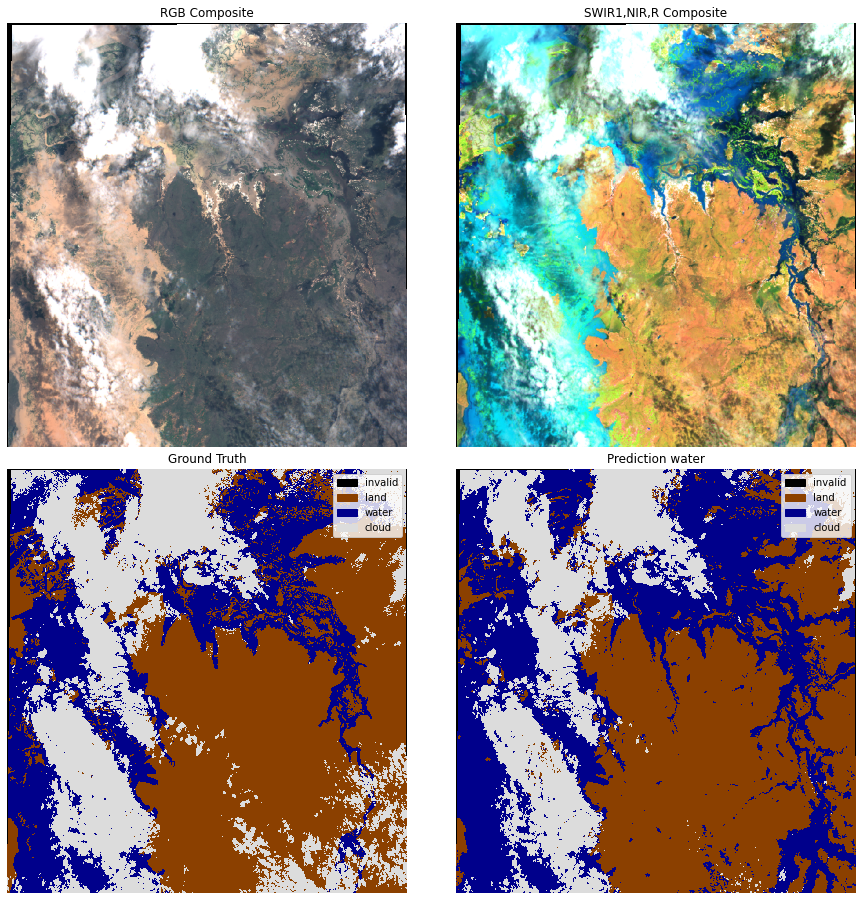

In [9]:
plot_inference_set(tiff_s2, gt, prediction, transform = transform)

(3105, 2)

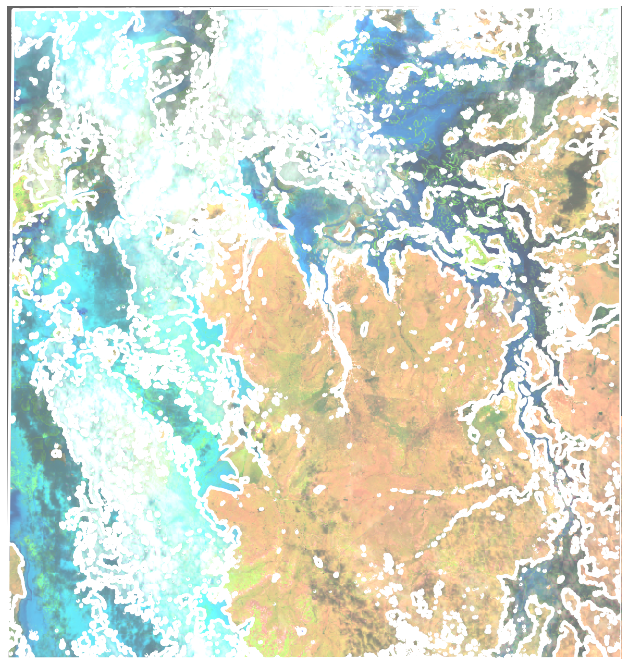

In [10]:
from ml4floods.models import postprocess
from ml4floods.visualization import plot_utils
import geopandas as gpd

prediction = prediction.astype(np.uint8)
geoms_polygons = postprocess.get_water_polygons(prediction, transform=transform)

data_out = gpd.GeoDataFrame({"geometry": geoms_polygons, "id": np.arange(len(geoms_polygons))})
fig, ax = plt.subplots(1,1, figsize=(12, 12))
data_out.plot("id",legend=False,categorical=True,ax=ax,facecolor="None",edgecolor="1",linewidth=3) 
plot_utils.plot_s2_swirnirred_image(tiff_s2, transform=transform, ax=ax, alpha=.6,
                             size_read = 600)
ax.axis('off')
data_out.shape
